# Exercise 1 - Dalia Smyrnov & Michael Rubinfeld
In this exercise we will try predicting the number of bicycle rentings from the given dataset and measure our success by using the RMSE loss function.

In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## EDA

#### First impressions on features

In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
0,2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980,5.354100,28.701,0.000000,35
1,2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028,85.425233,22.961,0.004489,251
2,2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032,2.040899,12.301,0.000242,53
3,2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981,26.682772,23.781,0.004489,296
4,2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980,5.851754,8.201,0.000000,16


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8164 non-null   object 
 1   season      8164 non-null   int64  
 2   holiday     8164 non-null   int64  
 3   workingday  8164 non-null   int64  
 4   weather     8164 non-null   int64  
 5   temp        8164 non-null   float64
 6   atemp       8164 non-null   float64
 7   humidity    8164 non-null   int64  
 8   windspeed   8164 non-null   float64
 9   pollution   8164 non-null   float64
 10  sunlight    8164 non-null   float64
 11  traffic     8164 non-null   float64
 12  count       8164 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 829.3+ KB


We can see that all types of the data we expect to have are correct except of datetime which will be converted to a datetime object later.

No missing values.

In [ ]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
count,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,2.510289,0.029397,0.683244,1.415483,20.244980,23.670160,61.835130,12.791334,47.152120,20.245980,0.004986,191.339784
std,1.117178,0.168928,0.465240,0.631242,7.796018,8.468725,19.255791,8.213914,72.882602,7.796018,0.006319,181.143178
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000304,0.821000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,3.693188,13.941000,0.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.684113,20.501000,0.000242,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,59.257746,26.241000,0.004489,285.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,754.304876,41.001000,0.015615,970.000000


In [ ]:
from typing import Sequence
def plot_simple_density_plot_of_feature(feature: str):
  plt.figure(figsize = (10,6))
  sns.set(style="darkgrid")
  sns.kdeplot(train[feature], shade = True)
  plt.show()

def plot_simple_density_plot_of_three_features(features: Sequence):
  figure, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)
  figure.set_size_inches(20,8)
  sns.set(style="darkgrid")
  sns.kdeplot(train[features[0]], shade = True, ax=ax1, color='lightblue')
  sns.kdeplot(train[features[1]], shade = True, ax=ax2, color='red')
  sns.kdeplot(train[features[2]], shade = True, ax=ax3, color='lightgreen')
  plt.show()

Now let's look for anomalies, skewness and outliers in the data: 

mean value very different from median (50%), extreme min or max values compared to the quartiles and everything else that looks funny.




Humidity, temp and atemp have min and max values that make sense but maybe hold some outliers which will be capped to lower noise.

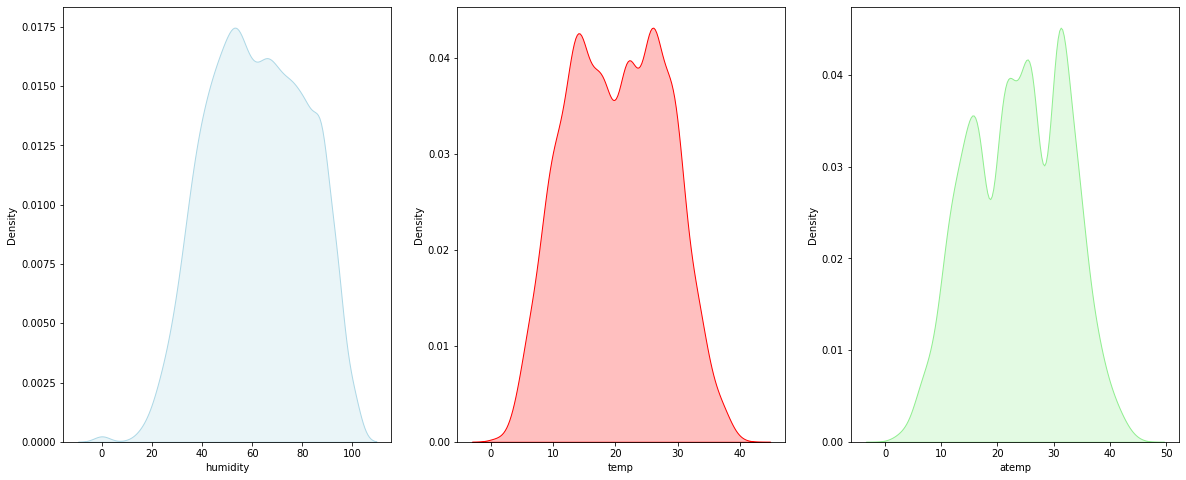

In [ ]:
plot_simple_density_plot_of_three_features(['humidity', 'temp', 'atemp'])

Seems alright. Humidity is a little right-skewd, will be treated. 

Pollution looks noisy. Let's see:

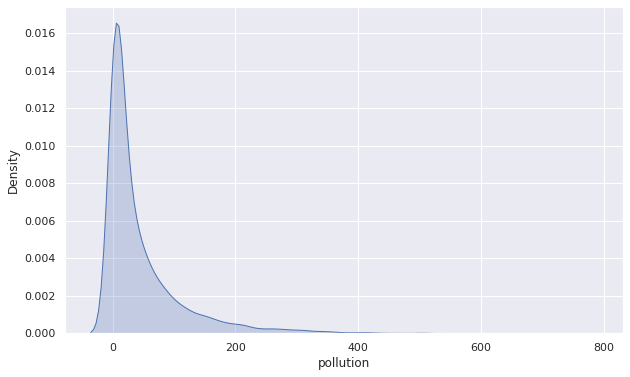

In [ ]:
plot_simple_density_plot_of_feature('pollution')

Pollution is noisy in the larger values. By looking at the density plot we can see it is somewhat chi-squared distributed. we may need to to reduce spersity.

#### Check for any surprises in the test set (things that were'nt present in the train set)

In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
0,2011-07-19 11:00:00,3,0,1,1,33.62,40.150,59,0.0000,10.317020,33.621,0.015615,127
1,2012-01-16 06:00:00,1,1,0,1,4.10,6.820,54,6.0032,3.502209,4.101,0.004489,13
2,2011-12-11 18:00:00,4,0,0,1,9.84,11.365,48,12.9980,25.945915,9.841,0.000000,163
3,2012-08-15 10:00:00,3,0,1,2,29.52,34.090,62,12.9980,116.935908,29.521,0.004489,233
4,2012-06-15 23:00:00,2,0,1,1,25.42,31.060,53,16.9979,120.824789,25.421,0.015615,222


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    2722 non-null   object 
 1   season      2722 non-null   int64  
 2   holiday     2722 non-null   int64  
 3   workingday  2722 non-null   int64  
 4   weather     2722 non-null   int64  
 5   temp        2722 non-null   float64
 6   atemp       2722 non-null   float64
 7   humidity    2722 non-null   int64  
 8   windspeed   2722 non-null   float64
 9   pollution   2722 non-null   float64
 10  sunlight    2722 non-null   float64
 11  traffic     2722 non-null   float64
 12  count       2722 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 276.6+ KB


In [ ]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count
count,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000
mean,2.495591,0.026084,0.673769,1.427259,20.188508,23.609866,62.040411,12.823574,49.463730,20.189508,0.004963,192.277002
std,1.113290,0.159414,0.468919,0.641599,7.779572,8.493596,19.215442,8.016061,76.609700,7.779572,0.006301,181.179744
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000292,0.821000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,3.798313,13.941000,0.000000,44.000000
50%,2.500000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,18.430172,20.501000,0.000242,146.000000
75%,3.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,60.885153,26.241000,0.004489,280.750000
max,4.000000,1.000000,1.000000,3.000000,39.360000,44.695000,100.000000,46.002200,695.650658,39.361000,0.015615,977.000000


No surprises.

#### More insightful time-oriented EDA

First, we'll extract as much information as possible from the datetime feature. And create new and creative features that are time-based and date-based. After that, we will see if it made sense to segment the datetime feature as we did.

In [ ]:
def create_datetime_segmentations(df):
  # split date column
  df['datetime'] = pd.to_datetime(df['datetime'])
  df['year'] = df['datetime'].dt.year
  df['month'] = df['datetime'].dt.month
  df['day'] = df['datetime'].dt.day
  df['hour'] = df['datetime'].dt.hour
  df['day of week'] = df['datetime'].dt.dayofweek
  df['week of year'] = df['datetime'].dt.weekofyear

  # new features
  df['ideal'] = df[['temp', 'windspeed']].apply(
      lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], 
      axis = 1)  # is it ideal weather in terms of humidity and temperature

  df['holiday'] = df[['month', 'day', 'holiday', 'year']].apply(
      lambda x: (x['holiday'], 1)[x['year'] == 2012 and 
                                  x['month'] == 10 and 
                                  (x['day'] in [30])], axis = 1)
  df['holiday'] = df[['month', 'day', 'holiday']].apply(
      lambda x: (x['holiday'], 1)[x['month'] == 12 and 
                                  (x['day'] in [24, 26, 31])], axis = 1)  
  # add more holidays not in original data
  
  df['workingday'] = df[['month', 'day', 'workingday']].apply(
      lambda x: (x['workingday'], 0)[x['month'] == 12 and 
                                     x['day'] in [24, 31]], axis = 1)
  
  df['peak'] = df[['hour', 'workingday']].apply(
      lambda x: (0, 1)[(x['workingday'] == 1 and 
                        ( x['hour'] == 8 or 
                         17 <= x['hour'] <= 18 or 
                         12 <= x['hour'] <= 13)) or 
                       (x['workingday'] == 0 and  
                        10 <= x['hour'] <= 19)], axis = 1)  # peak business times
  

  df['sticky'] = df[['humidity', 'workingday']].apply(
    lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], 
    axis = 1)  # if humidity is relatively high and its a working day, riding a bike may get you sticky

  # categorical numbers to names (according to similar dataset on kaggle)
  df['season'] = df['season'].map({1: 'Spring', 
                                   2 : 'Summer', 
                                   3 : 'Fall', 
                                   4 :'Winter' })
  
  df['weather'] = df['weather'].map({1: 'Clear', 
                                     2: 'Mist, Few clouds', 
                                     3: 'Light Snow, Rain, Thunder',
                                     4: 'Heavy Snow, Rain, Thunder'})

  df = df.drop(['datetime'], axis=1)

  return df

In [ ]:
train = create_datetime_segmentations(train)
test = create_datetime_segmentations(test)
warnings.filterwarnings('ignore')

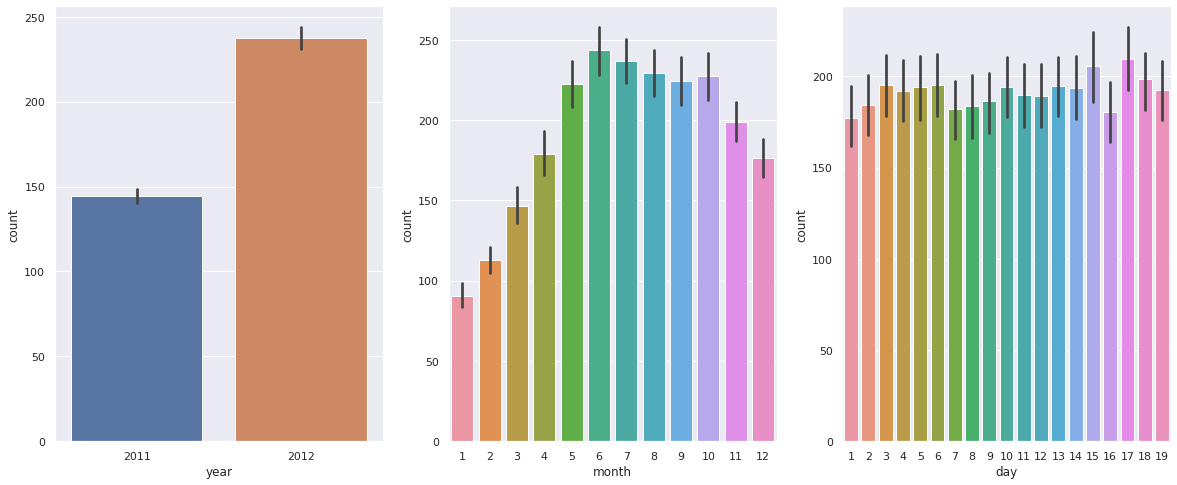

In [ ]:
# explore
figure, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,8)
sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3) 

### Conclusions:

Year is binary here.

Month matters since we can see that there is a peak in the summer and a sharp decline through the winter.

Days of month don't go beyond 19. maybe the rest are on the test set.

Now, let's check the distribution of bike rentals during the day, segmenting by type of day in binary ways, and also and different categorical segmentations.

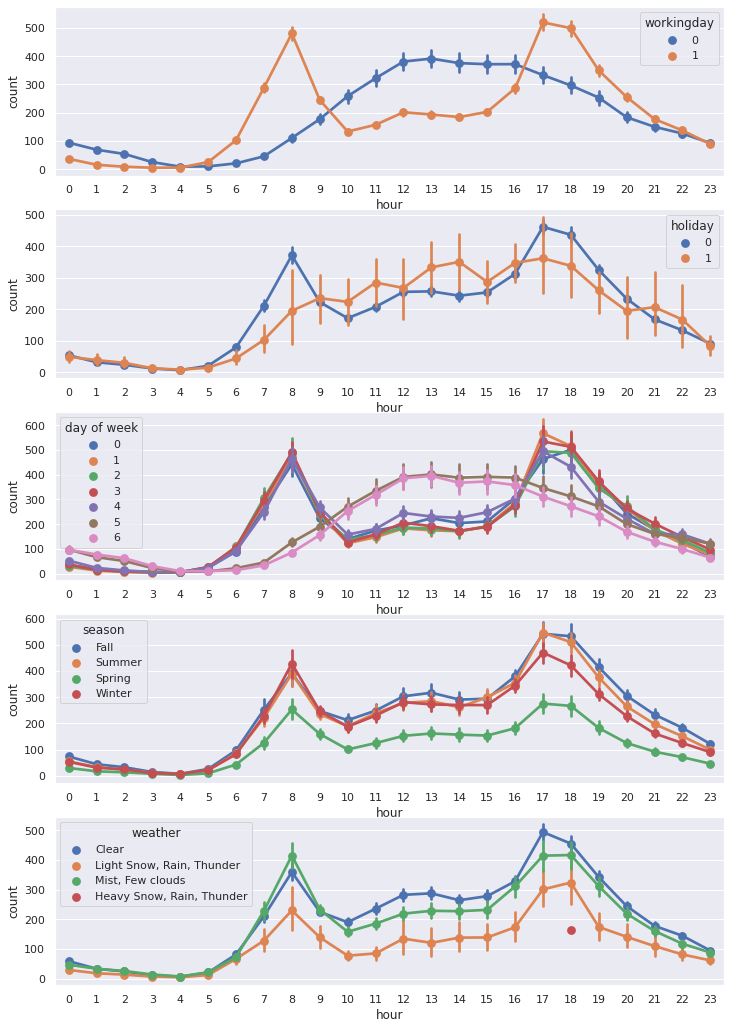

In [ ]:
# count of rental biks per hour
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5)
figure.set_size_inches(12, 18)
sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='day of week', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4])

We can see that bike renatals segmentations tell a story on the way customers behave on different kinds of days:

on working days we have two peaks of rents whereas on weekends we have a more evenly distributed scheme.

Weather plays a conciderate part - rentals are distributed the same during the day but increase and decrease based on the weather.

The distribution of bikes differs a lot when segmenting on working days vs. weekends but doesn't on holidays vs. regular days. this means that the fact that a certain day has a holiday in it doesn't yield much information, but knowing if its the weekend does. Because of that we assume that holiday will be a weak feature and working day will be a stronger one.

### Conclusion - our time-segmentations were just and do show a bigger picture. We will keep them as new features.

#### Correlation between features

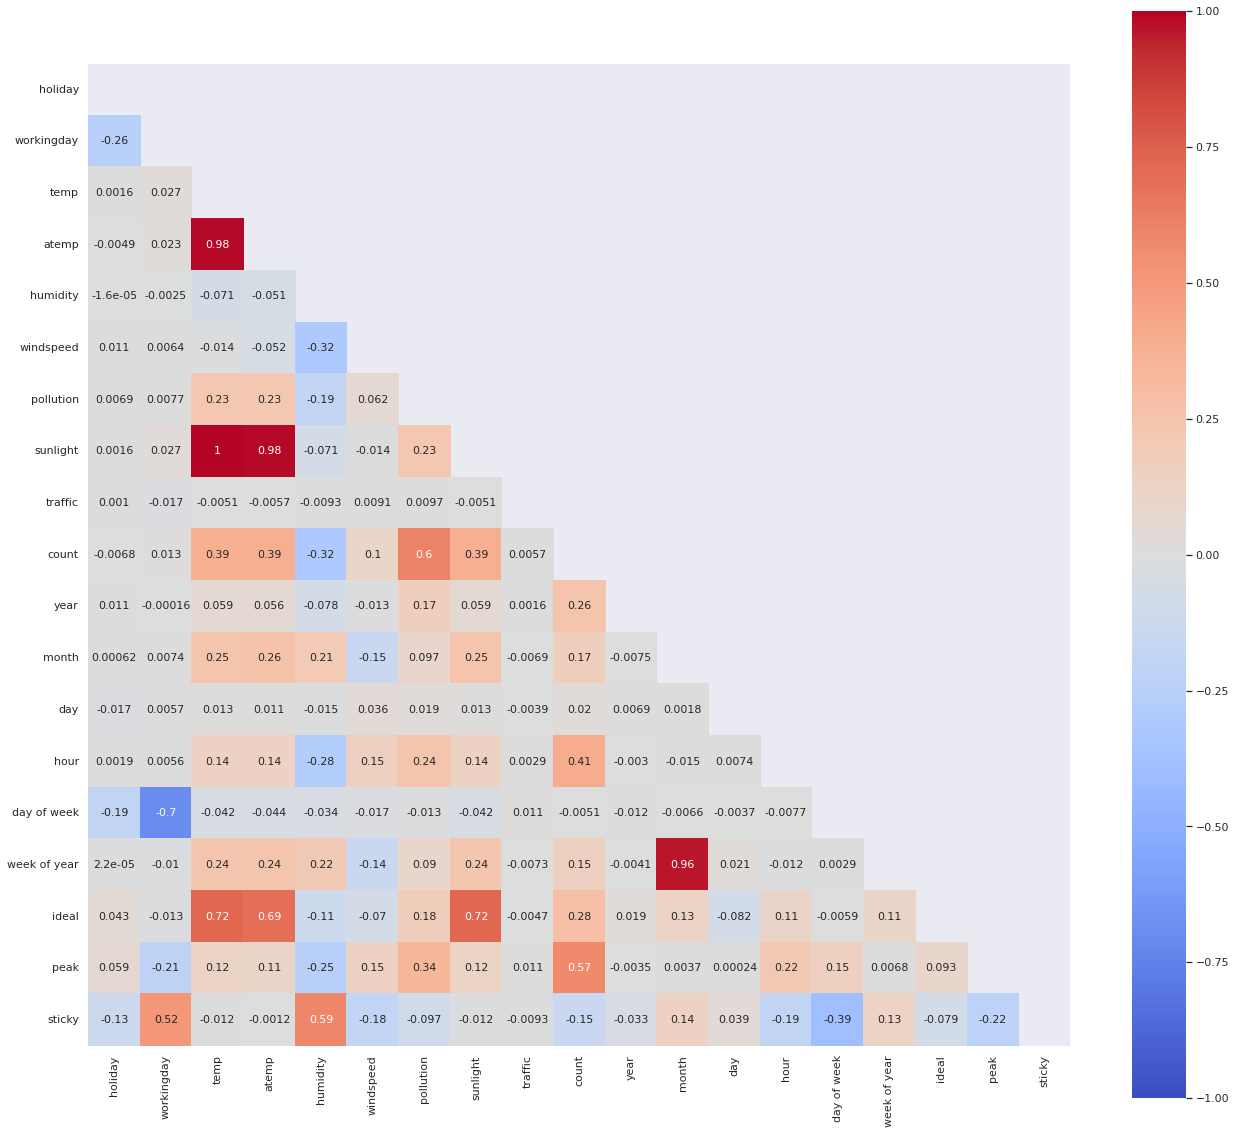

In [ ]:
# correlation plot
correlations = train.corr()
tri_matrix = np.triu(correlations)
plt.figure(figsize=(22,20))
sns.heatmap(correlations, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square = True, mask = tri_matrix)

high correlation between:
* temp-atemp
* temp-sunlight
* atemp-sunlight
* month-week of year

their correlation with the label may help to determine which of each pair to keep. Let's see their correlations:

temp: 0.39

atemp: 0.39

sunlight: 0.39

month: 0.17

week of year: 0.15

Not very helpful....

We will remove one of the pair according to feature importance.

## Preprocessing

#### Scaling
The pollution variable has a way larger standard deviation than any other feature and we've also seen that its right-skewd so a good idea may be to take its logarithmic value.

In [ ]:
train['pollution'] = np.log(train['pollution'])
test['pollution'] = np.log(test['pollution'])

train = train.rename(columns = {'pollution': 'log_pollution'})
test = test.rename(columns = {'pollution': 'log_pollution'})

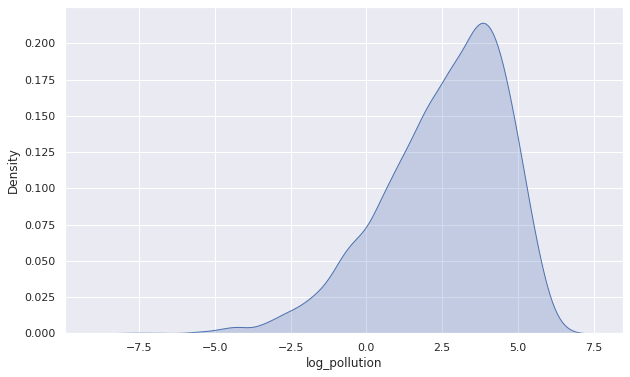

In [ ]:
plot_simple_density_plot_of_feature('log_pollution')

Now it got skewed a bit to the left side but its significately less skewed! the small tail will be taken care of by the scaler.

#### One hot encode categorical features
We have only two - season and weather. Let's OHC both. Also, we saw in a previous graph that year is binary. We shall binarize it also.

In [ ]:
print(train['season'].unique())
print(test['season'].unique())
print(train['weather'].unique())
print(test['weather'].unique())

['Fall' 'Summer' 'Spring' 'Winter']
['Fall' 'Spring' 'Winter' 'Summer']
['Clear' 'Light Snow, Rain, Thunder' 'Mist, Few clouds'
 'Heavy Snow, Rain, Thunder']
['Clear' 'Mist, Few clouds' 'Light Snow, Rain, Thunder']


In [ ]:
train['year'].value_counts()  # make sure its binary

2012    4100
2011    4064
Name: year, dtype: int64

All categorical values are in both.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df):
  # Apply one-hot encoder to each column with categorical data
  OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  OH_cols_df = pd.DataFrame(OH_encoder.fit_transform(df[['season']]))

  # One-hot encoding removed index; put it back
  OH_cols_df.index = df.index

  # Remove categorical columns (will replace with one-hot encoding)
  num_X_df = df.drop('season', axis=1)

  # Add one-hot encoded columns to numerical features
  df = pd.concat([num_X_df, OH_cols_df], axis=1)

  df = df.drop([3], axis=1)     
  df = df.rename(columns = {0: 'Clear', 1: 'Mist, Few clouds', 2: 'Light Snow, Rain, Thunder'})

  # same for weather
  OH_cols_df = pd.DataFrame(OH_encoder.fit_transform(df[['weather']]))
  OH_cols_df.index = df.index
  num_X_df = df.drop('weather', axis=1)
  df = pd.concat([num_X_df, OH_cols_df], axis=1)
  try:
    df = df.drop([3], axis=1)   
  except:
    pass  # weird bug if not in try-except
  df = df.rename(columns = {0: 'Spring', 1 : 'Summer', 2 : 'Fall' })

  # binarize year
  df['year'] = df['year'].replace({2012: 1, 2011: 0})
  df = df.rename(columns = {'year': 'year_2012'})

  return df

In [ ]:
train = one_hot_encode(train)
test = one_hot_encode(test)

#### Scale data
First scale the data then remove outliers easier

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_data_and_cap_outliers(df):
  scaler = StandardScaler()
  numerical_features = ['temp', 'atemp' ,'humidity',	'windspeed', 'log_pollution', 
                        'sunlight', 'traffic', 'month',	'day', 'hour', 
                        'day of week',	'week of year']
      
  df[numerical_features] = scaler.fit_transform(df[numerical_features])

  for feature in numerical_features:
    df.loc[df[feature] > 3, feature] = 3
    df.loc[df[feature] < -3, feature] = -3

  return df

In [ ]:
train = scale_data_and_cap_outliers(train)
test = scale_data_and_cap_outliers(test)

#### Final Sanity Check

In [ ]:
train.describe(), test.describe()

(           holiday   workingday          temp         atemp     humidity  \
 count  8164.000000  8164.000000  8.164000e+03  8.164000e+03  8164.000000   
 mean      0.029397     0.683244 -3.873371e-16 -2.555526e-16     0.000388   
 std       0.168928     0.465240  1.000061e+00  1.000061e+00     0.998854   
 min       0.000000     0.000000 -2.491807e+00 -2.705432e+00    -3.000000   
 25%       0.000000     0.000000 -8.087933e-01 -8.272307e-01    -0.770471   
 50%       0.000000     1.000000  3.271353e-02  6.729165e-02     0.008563   
 75%       0.000000     1.000000  7.690320e-01  8.726570e-01     0.787597   
 max       1.000000     1.000000  2.662422e+00  2.572545e+00     1.982116   
 
          windspeed  log_pollution      sunlight       traffic        count  \
 count  8164.000000    8164.000000  8.164000e+03  8.164000e+03  8164.000000   
 mean     -0.003668       0.004366  4.981045e-16 -7.281725e-16   191.339784   
 std       0.987042       0.984622  1.000061e+00  1.000061e+00   181

## Initial modeling
At this point we will build initial hyperparameter tuners for different models. After that we will calculate feature importance in each. Later we'll train again after gettind rid of weak features, which will hopefully yield better results.

In [ ]:
X_train = train.drop(['count'], axis=1)
y_train = train[['count']]

X_test = test.drop(['count'], axis=1)
y_test = test[['count']]

In [ ]:
def show_randomsearch_results(tuned_obj):
  print(f'best model negative RMSE is: {tuned_obj.best_score_}')
  print(f'best model hyperparameters are: {tuned_obj.best_params_}')

#### Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

def rf_tuner(X, y):
  rf = RandomForestRegressor(random_state=42)
  rf_params_grid = {'n_estimators': [300],
                    'min_samples_split': [2, 3, 4], 
                    'min_samples_leaf': [1, 2, 3],
                    'max_features': ['auto', 'sqrt', 'log2', 1/3]}

  initial_rf_RS = RandomizedSearchCV(estimator=rf,
                                    param_distributions=rf_params_grid,
                                    scoring='neg_root_mean_squared_error',
                                    n_iter=18,
                                    cv=3,
                                    verbose=3,
                                    n_jobs=-1,
                                    refit=True)

  tuned_rf = initial_rf_RS.fit(X, y)
  return tuned_rf

In [ ]:
warnings.filterwarnings('ignore')
initial_rf_RS = rf_tuner(X_train, y_train)
show_randomsearch_results(initial_rf_RS)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
best model negative RMSE is: -48.07625994728463
best model hyperparameters are: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto'}


#### XGBoost

In [ ]:
from xgboost import XGBRegressor

def xgb_tuner(X, y):
  xgb = XGBRegressor()
  xgb_params_grid = {'n_estimators': [300],
                     'min_child_weight': range(5, 25, 3),
                     'gamma': [0.5, 1, 1.5, 2, 3, 5],
                     'subsample': [0.5, 0.6, 0.8, 1.0],
                     'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
                     'max_depth': range(2, 10),
                     'learning_rate': [0.1, 0.01, 0.03, 0.05, 0.001]
                     }

  initial_xgb_RS = RandomizedSearchCV(estimator=xgb,
                                    param_distributions=xgb_params_grid,
                                    scoring='neg_root_mean_squared_error',
                                    n_iter=30,
                                    cv=3,
                                    verbose=3,
                                    n_jobs=-1,
                                    refit=True)

  tuned_xgb = initial_xgb_RS.fit(X, y)
  return tuned_xgb

In [ ]:
warnings.filterwarnings('ignore')
initial_xgb_RS = xgb_tuner(X_train, y_train)
show_randomsearch_results(initial_xgb_RS)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[09:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best model negative RMSE is: -41.665186807610986
best model hyperparameters are: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 20, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.6}


#### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def gb_tuner(X, y):
  gb = GradientBoostingRegressor(random_state=42)
  gb_params_grid = {'n_estimators' : [300],
                    'learning_rate': [0.1, 0.01, 0.03, 0.05, 0.001],
                    'subsample'    : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                    'min_samples_split': [2, 3, 4, 6], 
                    'min_samples_leaf': [1, 2, 3, 4],
                    'max_depth'    : range(2, 10),
                    'max_features': ['auto', 'sqrt', 'log2', 1/3]
                    }

  initial_gb_RS = RandomizedSearchCV(estimator=gb,
                                    param_distributions=gb_params_grid,
                                    scoring='neg_root_mean_squared_error',
                                    n_iter=30,
                                    cv=3,
                                    verbose=3,
                                    n_jobs=-1,
                                    refit=True)

  tuned_gb = initial_gb_RS.fit(X, y)
  return tuned_gb

In [ ]:
warnings.filterwarnings('ignore')
initial_gb_RS = gb_tuner(X_train, y_train)
show_randomsearch_results(initial_gb_RS)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
best model negative RMSE is: -42.44813805096499
best model hyperparameters are: {'subsample': 0.3, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 8, 'learning_rate': 0.05}


##### Dimensionality reduction option 1 - feature importance based on trained tree models

In [ ]:
best_initial_rf = initial_rf_RS.best_estimator_
best_initial_xgb = initial_xgb_RS.best_estimator_
best_initial_gb = initial_gb_RS.best_estimator_

def find_feature_importance(model, columns):
  importance = model.feature_importances_
  importance *= 100 / np.max(importance)  # Normalize
  importance = pd.DataFrame(importance, index=columns, columns=["Importance"])
  importance = importance.sort_values(by=['Importance'], ascending=False)
  return importance

initial_rf_feature_importance_dict = find_feature_importance(best_initial_rf, X_train.columns)
initial_xgb_feature_importance_dict = find_feature_importance(best_initial_xgb, X_train.columns)
initial_gb_feature_importance_dict = find_feature_importance(best_initial_gb, X_train.columns)

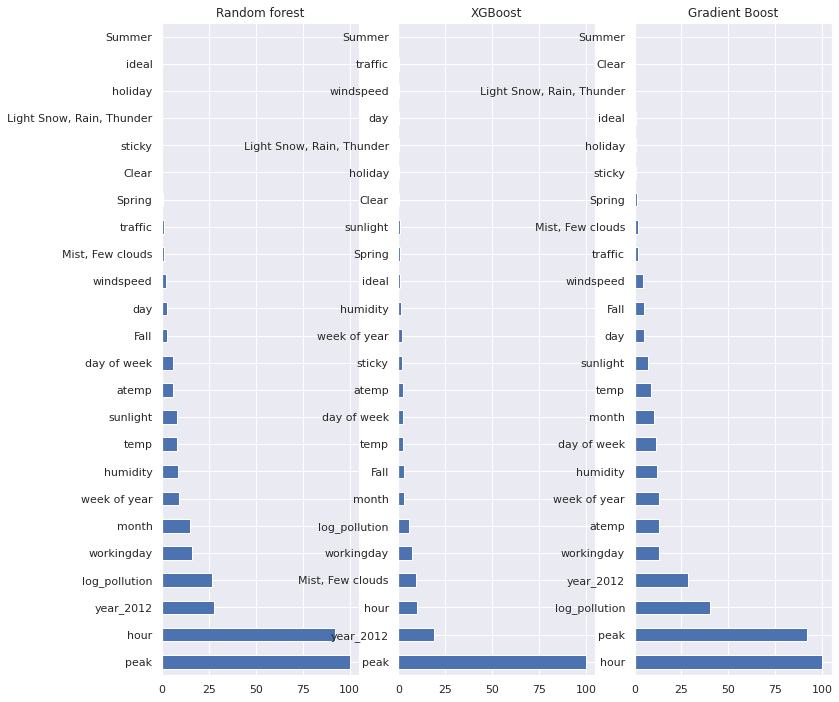

In [ ]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
initial_rf_feature_importance_dict.plot(kind='barh', ax=axes[0], legend=False, title='Random forest')
initial_xgb_feature_importance_dict.plot(kind='barh', ax=axes[1], legend=False, title='XGBoost')
initial_gb_feature_importance_dict.plot(kind='barh', ax=axes[2], legend=False, title='Gradient Boost')

We can see that the non-important features are kind of the same between the models (makes sense because they're all tree-based).

We will reduce dimentionality in two steps:

1. recall the pairs of features with high correlation and remove the less important one from each

2. remove all the features which recieved sub-zero importance scores in all three models.

High correlation between:
* temp-atemp
* temp-sunlight
* atemp-sunlight
* month-week of year

temp > atemp always.

sunlight is as important as temp or less.

month > week of year

In [ ]:
removed_due_to_correlation = ['atemp', 'sunlight', 'week of year']

# absolute bad features throughout
removed_due_to_importance = ['Summer', 'ideal', 'Light Snow, Rain, Thunder', 
                             'Clear', 'traffic']

features_to_remove = removed_due_to_correlation + removed_due_to_importance

In [ ]:
X_train_dim_reduction_opt1 = X_train.drop(features_to_remove, axis=1)

Now let's train again and see the new results

In [ ]:
warnings.filterwarnings('ignore')
rf_RS_opt1 = rf_tuner(X_train_dim_reduction_opt1, y_train)
show_randomsearch_results(rf_RS_opt1)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
best model negative RMSE is: -48.1692441751257
best model hyperparameters are: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto'}


In [ ]:
warnings.filterwarnings('ignore')
xgb_RS_opt1 = xgb_tuner(X_train_dim_reduction_opt1, y_train)
show_randomsearch_results(xgb_RS_opt1)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[09:12:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best model negative RMSE is: -41.35385412184754
best model hyperparameters are: {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 11, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.8}


In [ ]:
warnings.filterwarnings('ignore')
gb_RS_opt1 = gb_tuner(X_train_dim_reduction_opt1, y_train)
show_randomsearch_results(gb_RS_opt1)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
best model negative RMSE is: -42.984750173425276
best model hyperparameters are: {'subsample': 0.9, 'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.1}


#### Dimensionality reduction option 2 - feature importance by estimating mutual information between each feature and the label

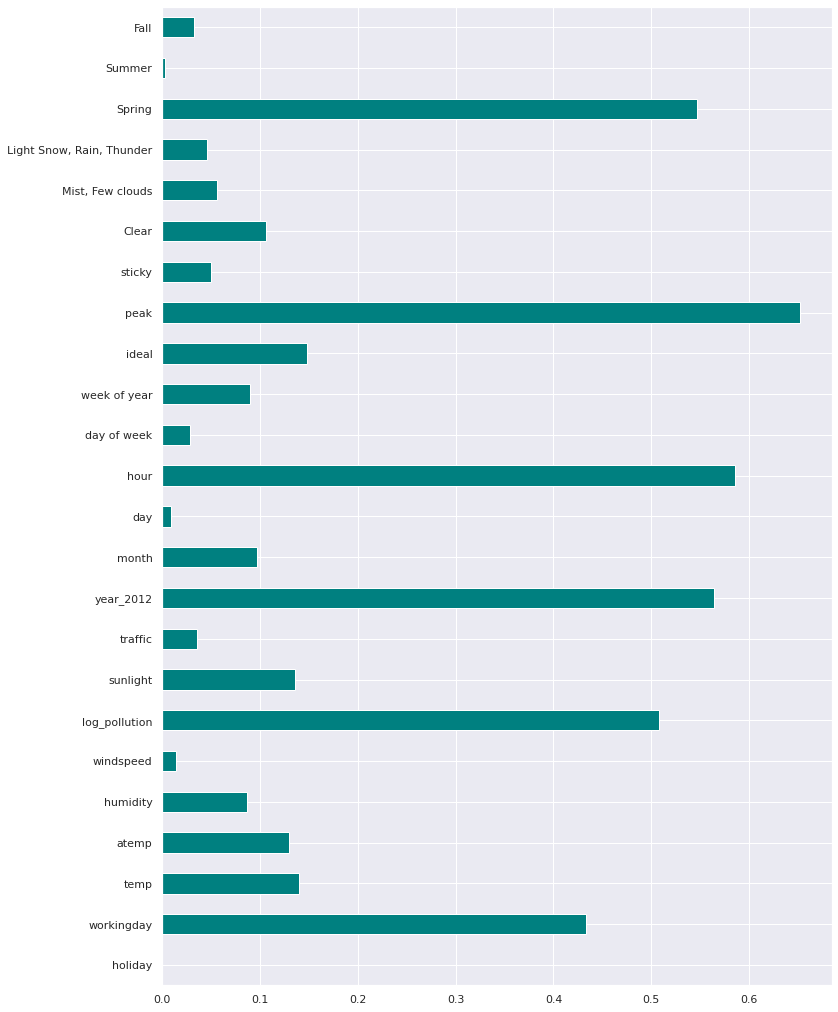

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)
plt.figure(figsize=(12,18))
feat_importances = pd.Series(importances, X_train.columns[:len(X_train.columns)])
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

According to this method the features with high correlation between themselves which we found earlier, are similarly correlated to the label. In that case, we can remove all but one of them. Other weak features will be removed too.

In [ ]:
removed_due_to_correlation = ['atemp', 'temp', 'week of year']

# removing according to XGBoost since it yielded the best results earlier
removed_due_to_importance = ['Summer', 'day', 'holiday', 'Fall']

features_to_remove = removed_due_to_correlation + removed_due_to_importance

In [ ]:
X_train_dim_reduction_opt2 = X_train.drop(features_to_remove, axis=1)

In [ ]:
warnings.filterwarnings('ignore')
rf_RS_opt2 = rf_tuner(X_train_dim_reduction_opt2, y_train)
show_randomsearch_results(rf_RS_opt2)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
best model negative RMSE is: -49.767814143038976
best model hyperparameters are: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto'}


In [ ]:
warnings.filterwarnings('ignore')
xgb_RS_opt2 = xgb_tuner(X_train_dim_reduction_opt2, y_train)
show_randomsearch_results(xgb_RS_opt2)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[09:19:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best model negative RMSE is: -43.68726273795064
best model hyperparameters are: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 8, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.6}


In [ ]:
warnings.filterwarnings('ignore')
gb_RS_opt2 = gb_tuner(X_train_dim_reduction_opt2, y_train)
show_randomsearch_results(gb_RS_opt2)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
best model negative RMSE is: -44.71140507535241
best model hyperparameters are: {'subsample': 0.9, 'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 8, 'learning_rate': 0.03}


#### Let's look at the winning methods for each model:

All models did not benefit from dimensionality reduction in this iteration of training. So, we will use the initial models trained with no dimensionality reduction:

In [ ]:
best_rf = initial_rf_RS.best_estimator_
best_xgb = initial_xgb_RS.best_estimator_
best_gb = initial_gb_RS.best_estimator_

In [ ]:
y_hat_rf = best_rf.predict(X_test)
y_hat_xgb = best_xgb.predict(X_test)
y_hat_gb = best_gb.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_score_rf = np.sqrt(mean_squared_error(y_test, y_hat_rf))
rmse_score_xgb = np.sqrt(mean_squared_error(y_test, y_hat_xgb))
rmse_score_gb = np.sqrt(mean_squared_error(y_test, y_hat_gb))

print(f'RMSE score for Random Forest: {rmse_score_rf}, RMSE score for XGBoost: {rmse_score_xgb}, RMSE score for Gradient Boosting:{rmse_score_gb}')

RMSE score for Random Forest: 49.05019226597539, RMSE score for XGBoost: 48.28554174555933, RMSE score for Gradient Boosting:48.063902561356336


In [ ]:
new_features_created = ['year_2012', 'month', 'day', 'hour', 'day of week', 
                        'week of year', 'ideal', 'workingday', 'peak', 
                        'sticky', 'log_pollution']

results = {'model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
           'Score (RMSE)': [rmse_score_rf, rmse_score_xgb, rmse_score_gb],
           'Hyperparams used': [[initial_rf_RS.best_params_], 
                                [initial_xgb_RS.best_params_], 
                                [initial_gb_RS.best_params_]],
           'Features dropped': [['None'], ['None'], ['None']],
           'New features created': [new_features_created, new_features_created, 
                                    new_features_created],
           'Runtime trainining + inference (seconds)': [180, 120, 60],
           'Hardware used (GPU/CPU/TPU)': ['CPU', 'CPU', 'CPU'],
           'Explainability (top 3 features)': [['peak', 'hour', 'year_2012'], 
                                               ['peak', 'year_2012', 'hour'], 
                                               ['hour', 'peak', 'log_pollution']]
           }

results_df = pd.DataFrame(results)
results_df

,model,Score (RMSE),Hyperparams used,Features dropped,New features created,Runtime trainining + inference (seconds),Hardware used (GPU/CPU/TPU),Explainability (top 3 features)
0,Random Forest,49.050192,"[{'n_estimators': 300, 'min_samples_split': 3,...",[None],"[year_2012, month, day, hour, day of week, wee...",180,CPU,"[peak, hour, year_2012]"
1,XGBoost,48.285542,"[{'subsample': 1.0, 'n_estimators': 300, 'min_...",[None],"[year_2012, month, day, hour, day of week, wee...",120,CPU,"[peak, year_2012, hour]"
2,Gradient Boosting,48.063903,"[{'subsample': 0.3, 'n_estimators': 300, 'min_...",[None],"[year_2012, month, day, hour, day of week, wee...",60,CPU,"[hour, peak, log_pollution]"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_to_save = 'drive/My Drive/EX1_MICHAEL_RUBINFELD_AND_DALIA_SMYRNOV/exercise1.csv'
results_df.to_csv(path_to_save)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Conclusions
1. Gradient Boosting outperformed XGBoost and Random Forest for this task.

2. Dimensionality reduction did not benefit the models' abilities to predict bike rentals. This is maybe due to the fact that we didn't have many features to begin with, and had plenty of data in comparison to the limited amount of features.

